# Checking for overfitting against mass

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_unit import WMSE
from pitchfuncs_unit import InversePCA
from pitchfuncs_unit import emulator
from pitchfuncs_unit import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
from scipy import stats
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json
import matplotlib.pyplot as plt

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


2024-05-17 17:16:14.892905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 17:16:14.892933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 17:16:14.893768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 17:16:14.898556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 17:16:15.403730: W tensorflow/compiler/tf2

## Import emulator:

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-05-17 17:16:16.694642: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-17 17:16:16.694666: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-05-17 17:16:16.694670: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-05-17 17:16:16.694777: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-05-17 17:16:16.694796: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-05-17 17:16:16.694800: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.171.4


## Define emu

In [3]:
inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
emu_inps = [1,0.014, 0.26, 2, 5]

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,40+1)]
emu_outs = pitchfork.predict([emu_inps])[0]

emu = pd.DataFrame([emu_inps+list(emu_outs)], columns = inputs+outputs)

## Function for overfit test plotting

In [25]:
def overfit_plot(emulator, emu_inps, x_label, x_min, x_max, y_label, points=1000):
    inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
    emu_df = pd.DataFrame(emu_inps, columns=inputs)
    emu_array = pd.concat([emu_df]*points)

    x = np.linspace(x_min, x_max, points)
    emu_array[x_label] = x

    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,40+1)]
    preds = pd.DataFrame(emulator.predict(emu_array.values), columns = outputs)
    y = preds[y_label]

    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

notebook_x_label='initial_Zinit'
x_min = 0.0038
x_max = 0.04
points=10000

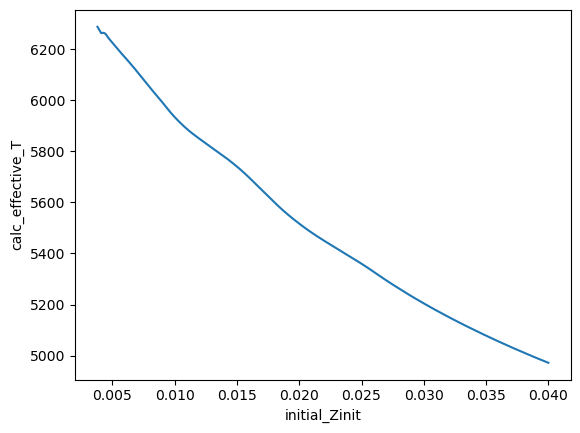

In [26]:
overfit_plot(emulator=pitchfork, emu_inps=emu[inputs], x_label=notebook_x_label, x_min=x_min, x_max=x_max, y_label='calc_effective_T',points=points)

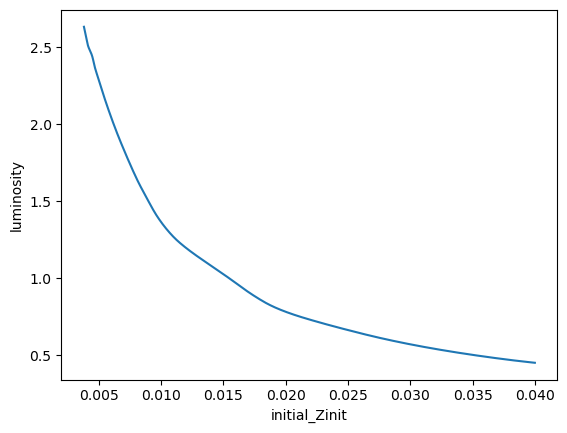

In [27]:
overfit_plot(emulator=pitchfork, emu_inps=emu[inputs], x_label=notebook_x_label, x_min=x_min, x_max=x_max, y_label='luminosity',points=points)

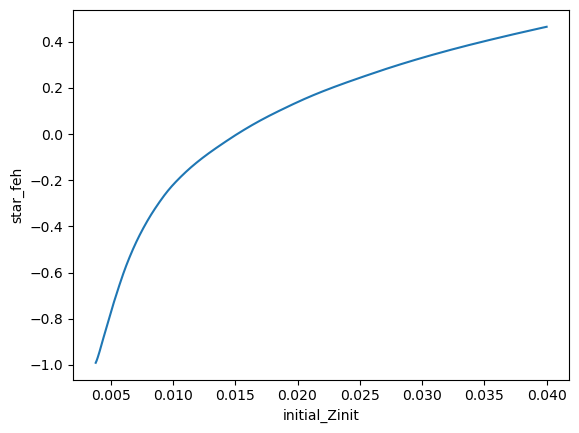

In [28]:
overfit_plot(emulator=pitchfork, emu_inps=emu[inputs], x_label=notebook_x_label, x_min=x_min, x_max=x_max, y_label='star_feh',points=points)

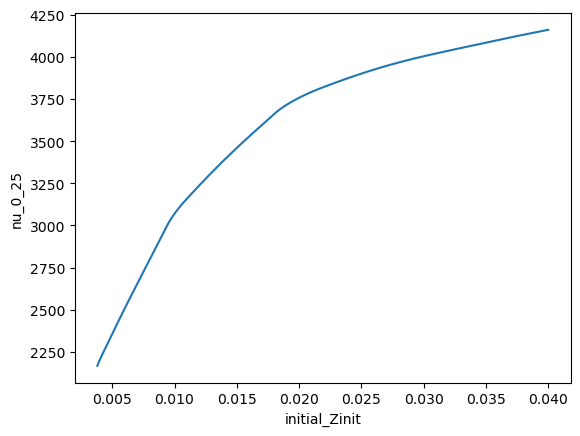

In [29]:
overfit_plot(emulator=pitchfork, emu_inps=emu[inputs], x_label=notebook_x_label, x_min=x_min, x_max=x_max, y_label='nu_0_25',points=points)

## Function for likelihood plotting

In [32]:
def logl_plot(emulator, emu_inps, emu_obs, x_label, x_min, x_max, sigma, points=1000):
    inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
    emu_df = pd.DataFrame(emu_inps, columns=inputs)
    emu_array = pd.concat([emu_df]*points)
    
    x = np.linspace(x_min, x_max, points)
    emu_array[x_label] = x

    sigma_inv = np.linalg.inv(sigma)

    _,log_sigma_det = np.linalg.slogdet(sigma)
    
    m = emulator.predict(emu_array.values)
    
    y = np.empty(points)

    for i in range(points):
        residual_matrix = np.matrix(m[i,:]-emu_obs)
        
        y[i] = -(len(m)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)-(0.5*residual_matrix*sigma_inv*residual_matrix.T).flat[0]

    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel('logl')

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz

# obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+0.01*np.abs(((n_max-n_min)/2+n_min)-i) for i in range(n_min,n_max+1)])
obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(6,40+1)])

pitchfork_ranges = pitchfork_info['parameter_ranges']

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs


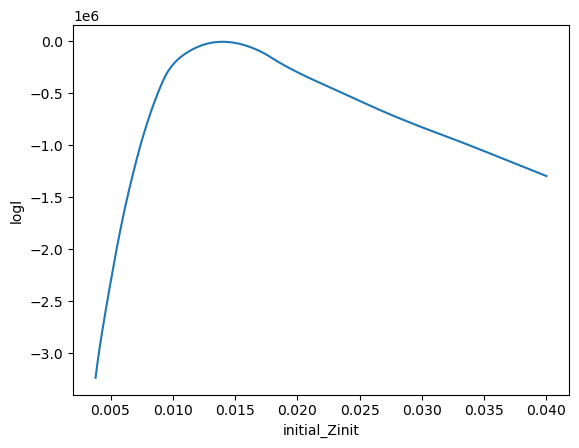

In [33]:
logl_plot(pitchfork, emu_inps=emu[inputs], emu_obs=emu[outputs], x_label=notebook_x_label, x_min=x_min, x_max=x_max, sigma=sigma,points=points)